<a href="https://colab.research.google.com/github/megcp/Research-project-sentiment-driven-stock-market-prediction/blob/main/RP6_logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing dependencies
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
stock = pd.read_csv('/content/drive/My Drive/Research Project/apple_dataframe_ready_for_ML_3.csv')

In [ ]:
stock.head()

,Date,Average Sentiment Score,open,high,low,close,volume,daily return,7-day rolling avg,14-day EMA,...,sentiment 14D shift,sentiment 30D shift,Sentiment 5D Rolling Avg,Sentiment 10D Rolling Avg,Sentiment 14D Rolling Avg,encoded sentiment 1D shift,encoded sentiment 5D shift,enocded sentiment 7D shift,encoded sentiment 10D shift,encoded sentiment 14D shift
0,2022-05-10,0.057865,155.52,156.7400,152.93,154.51,115366736.0,0.016112,157.725714,159.349249,...,-0.001057,0.210294,0.003697,0.032672,0.071413,0.0,0.0,-1.0,0.0,0.0
1,2022-05-11,0.000212,153.50,155.4500,145.81,146.50,142689825.0,-0.051841,156.088571,157.636016,...,0.001353,0.497262,0.003439,0.018439,0.071331,0.0,0.0,-1.0,1.0,0.0
2,2022-05-12,-0.492591,142.77,146.2000,138.80,142.56,182602041.0,-0.026894,153.671429,155.625881,...,0.968269,0.002144,-0.095079,-0.091322,-0.033016,0.0,0.0,0.0,1.0,1.0
3,2022-05-13,-0.000451,144.59,148.1050,143.11,147.11,113990852.0,0.031916,150.970000,154.490430,...,-0.296904,0.006650,-0.095159,-0.071573,-0.011841,-1.0,0.0,0.0,-1.0,-1.0
4,2022-05-16,0.189421,145.55,147.5199,144.18,145.54,86643781.0,-0.010672,149.365714,153.297039,...,0.000342,0.203714,-0.049109,-0.028492,0.001665,0.0,0.0,0.0,-1.0,0.0


In [ ]:
# convert date into datetime
stock['Date'] = pd.to_datetime(stock['Date'])

# set date as index
stock.set_index('Date', inplace=True)
# Shift the target variable back a day so that we are using today's information to predict tomorrow's movement
stock['movement (shifted -1)'] = stock['movement'].shift(-1)

# dropping na rows created from shifting movement
stock.dropna(inplace=True)

# dropping 'movement' column
stock.drop(columns=['movement'], inplace=True)

# splitting the data - maintaining chronological order as it is time-series data
split_ratio = 0.7
split_point = int(len(stock) * split_ratio)

train = stock.iloc[:split_point]
test = stock.iloc[split_point:]

# seperate features and target
X_train = train.drop(columns=['movement (shifted -1)'])
y_train = train['movement (shifted -1)']
X_test = test.drop(columns=['movement (shifted -1)'])
y_test = test['movement (shifted -1)']

In [ ]:
# scale data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# extract the feature names - to be used later
feature_names = X_train.columns

In [ ]:
stock.shape

(518, 37)

Best k:  8
Selected Features:  Index(['Average Sentiment Score', 'high', 'year', 'daily variation', 'MACD',
       'sentiment 14D shift', 'Sentiment 5D Rolling Avg',
       'encoded sentiment 1D shift'],
      dtype='object')
Best Test Accuracy:  0.5192307692307693
Train Accuracy:  0.56353591160221
Test Accuracy (after final fit):  0.5192307692307693

Classification Report on Test Set:
              precision    recall  f1-score   support

        -1.0       0.49      0.23      0.31        74
         1.0       0.53      0.78      0.63        82

    accuracy                           0.52       156
   macro avg       0.51      0.51      0.47       156
weighted avg       0.51      0.52      0.48       156


Confusion Matrix:
[[17 57]
 [18 64]]


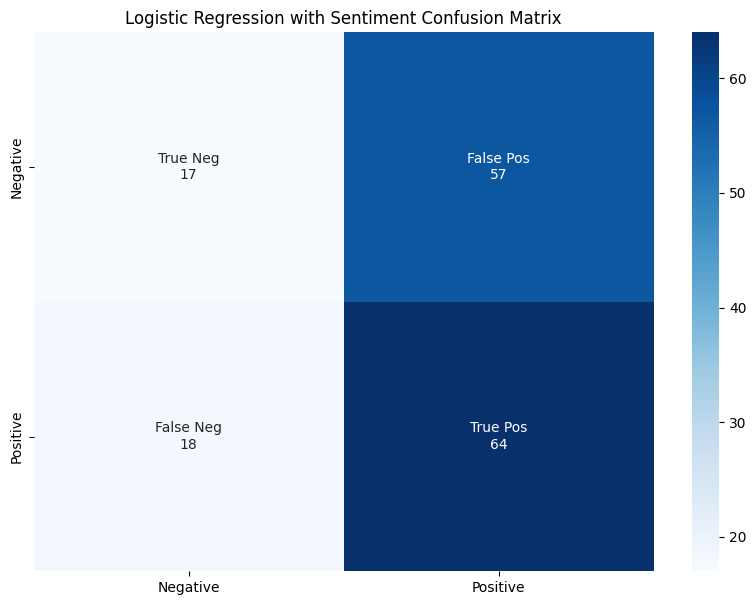

LogisticRegression(C=1, random_state=42, solver='liblinear')


In [ ]:
def LR(X_train_scaled, X_test_scaled, y_train, y_test, feature_names, k_values, param_grid):

    best_model = None
    best_score = 0
    best_k = None
    best_selected_features = None
# going through each value of k to determine the best number of k based on mutual infomation that score the best testing accuracy
    for k in k_values:
        select = SelectKBest(score_func=mutual_info_classif, k=k)
        X_train_selected = select.fit_transform(X_train_scaled, y_train)
        X_test_selected = select.transform(X_test_scaled)

         # 5 split cross validation for timeseries data- maintains chronocological order of the data
        # grid search to selcect best parameters from the parameters grid
        tscv = TimeSeriesSplit(n_splits=5)
        lr = LogisticRegression(random_state=42)
        grid_search = GridSearchCV(lr, param_grid, cv=tscv)
        grid_search.fit(X_train_selected, y_train)

        # predict the test data
        y_test_pred = grid_search.best_estimator_.predict(X_test_selected)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        # storing the best test accuracy and retreiving the feature names of the k features used
        if test_accuracy > best_score:
            best_score = test_accuracy
            best_model = grid_search.best_estimator_
            best_k = k
            best_selected_features = feature_names[select.get_support()]

    print('Best k: ', best_k)
    print('Selected Features: ', best_selected_features)
    print('Best Test Accuracy: ', best_score)
    # fitting the entire dataset with the selcted k features and parameters selcted above
    selector = SelectKBest(score_func=mutual_info_classif, k=best_k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    best_model.fit(X_train_selected, y_train)
    # predicting the test data
    y_train_pred = best_model.predict(X_train_selected)
    y_test_pred = best_model.predict(X_test_selected)

    # obtaining evaluation metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Train Accuracy: ', train_accuracy)
    print('Test Accuracy (after final fit): ', test_accuracy)
    print('\nClassification Report on Test Set:')
    print(classification_report(y_test, y_test_pred))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_test_pred))

    #plotting confusion matrix
    y_test_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    auc = round(roc_auc_score(y_test, y_test_pred_proba), 4)

    cm = confusion_matrix(y_test, y_test_pred)
    matrix_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    matrix_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(matrix_names, matrix_counts)]
    labels = np.asarray(labels).reshape(2, 2)

    # caluating false postive and true postive rate and auc score
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Logistic Regression with Sentiment Confusion Matrix')
    plt.show()

    return best_model, fpr, tpr, auc, y_test, y_test_pred

k_values = list(range(5, 36))
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}

best_model, fpr, tpr, auc, y_test, y_test_pred = LR(X_train_scaled, X_test_scaled, y_train, y_test, feature_names, k_values, param_grid)
print(best_model)


# LR without sentiment

In [ ]:
X_train.drop(columns=['Average Sentiment Score','encoded sentiment','sentiment 1D shift', 'sentiment 5D shift', 'sentiment 7D shift',
       'sentiment 10D shift', 'sentiment 14D shift', 'sentiment 30D shift',
       'Sentiment 5D Rolling Avg', 'Sentiment 10D Rolling Avg',
       'Sentiment 14D Rolling Avg', 'encoded sentiment 1D shift',
       'encoded sentiment 5D shift', 'enocded sentiment 7D shift',
       'encoded sentiment 10D shift', 'encoded sentiment 14D shift'], inplace = True)
X_test.drop(columns=['Average Sentiment Score','encoded sentiment','sentiment 1D shift', 'sentiment 5D shift', 'sentiment 7D shift',
       'sentiment 10D shift', 'sentiment 14D shift', 'sentiment 30D shift',
       'Sentiment 5D Rolling Avg', 'Sentiment 10D Rolling Avg',
       'Sentiment 14D Rolling Avg', 'encoded sentiment 1D shift',
       'encoded sentiment 5D shift', 'enocded sentiment 7D shift',
       'encoded sentiment 10D shift', 'encoded sentiment 14D shift'], inplace = True)

In [ ]:
# scale data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# extract the feature names - to be used later
feature_names = X_train.columns

Best k:  11
Selected Features:  Index(['high', 'close', '7-day rolling avg', 'change', 'avg gain', 'avg loss',
       'year', 'daily variation', 'MACD', 'MACD Signal Line', '%D'],
      dtype='object')
Best Test Accuracy:  0.5192307692307693
Train Accuracy:  0.5883977900552486
Test Accuracy (after final fit):  0.42948717948717946

Classification Report on Test Set:
              precision    recall  f1-score   support

        -1.0       0.38      0.32      0.35        74
         1.0       0.46      0.52      0.49        82

    accuracy                           0.43       156
   macro avg       0.42      0.42      0.42       156
weighted avg       0.42      0.43      0.42       156


Confusion Matrix:
[[24 50]
 [39 43]]


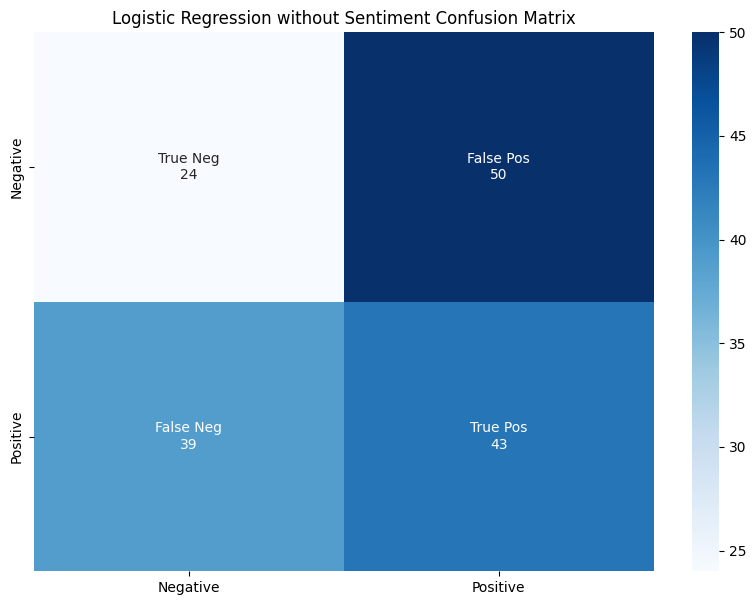

LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear')


In [ ]:
def LR(X_train_scaled, X_test_scaled, y_train, y_test, feature_names, k_values, param_grid):

    best_model = None
    best_score = 0
    best_k = None
    best_selected_features = None

    for k in k_values:
        select = SelectKBest(score_func=mutual_info_classif, k=k)
        X_train_selected = select.fit_transform(X_train_scaled, y_train)
        X_test_selected = select.transform(X_test_scaled)

        tscv = TimeSeriesSplit(n_splits=5)
        lr = LogisticRegression(random_state=42)

        grid_search = GridSearchCV(lr, param_grid, cv=tscv)
        grid_search.fit(X_train_selected, y_train)

        y_test_pred = grid_search.best_estimator_.predict(X_test_selected)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        if test_accuracy > best_score:
            best_score = test_accuracy
            best_model = grid_search.best_estimator_
            best_k = k
            best_selected_features = feature_names[select.get_support()]

    print('Best k: ', best_k)
    print('Selected Features: ', best_selected_features)
    print('Best Test Accuracy: ', best_score)

    selector = SelectKBest(score_func=mutual_info_classif, k=best_k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    best_model.fit(X_train_selected, y_train)

    y_train_pred = best_model.predict(X_train_selected)
    y_test_pred = best_model.predict(X_test_selected)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Train Accuracy: ', train_accuracy)
    print('Test Accuracy (after final fit): ', test_accuracy)
    print('\nClassification Report on Test Set:')
    print(classification_report(y_test, y_test_pred))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_test_pred))

    y_test_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    auc = round(roc_auc_score(y_test, y_test_pred_proba), 4)

    cm = confusion_matrix(y_test, y_test_pred)
    matrix_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    matrix_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(matrix_names, matrix_counts)]
    labels = np.asarray(labels).reshape(2, 2)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Logistic Regression without Sentiment Confusion Matrix')
    plt.show()

    return best_model, fpr, tpr, auc, y_test, y_test_pred

k_values = list(range(5, 19))
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}

best_model1, fpr1, tpr1, auc1, y_test, y_test_pred = LR(X_train_scaled, X_test_scaled, y_train, y_test, feature_names, k_values, param_grid)
print(best_model1)


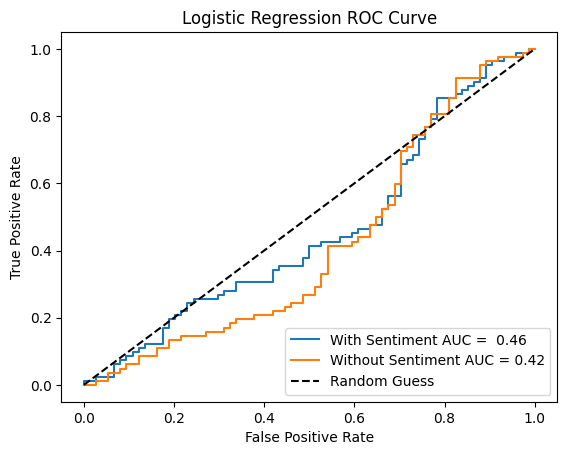

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label= f'With Sentiment AUC =  {auc:.2f}')
plt.plot(fpr1, tpr1, label=f'Without Sentiment AUC = {auc1:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.show()